In [8]:
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter

# Define the folder containing the images
image_folder = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images'

# Paths to the text files
train_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_variant_train.txt'
test_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_variant_test.txt'
val_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_variant_trainval.txt'

# Define label mapping with updated aircraft models
label_mapping = {
    "707-320": 0,
    "727-200": 1,
    "737-200": 2,
    "737-300": 3,
    "737-400": 4,
    "737-500": 5,
    "737-600": 6,
    "737-700": 7,
    "737-800": 8,
    "737-900": 9,
    "747-100": 10,
    "747-200": 11,
    "747-300": 12,
    "747-400": 13,
    "757-200": 14,
    "757-300": 15,
    "767-200": 16,
    "767-300": 17,
    "767-400": 18,
    "777-200": 19,
    "777-300": 20,
    "A300B4": 21,
    "A310": 22,
    "A318": 23,
    "A319": 24,
    "A320": 25,
    "A321": 26,
    "A330-200": 27,
    "A330-300": 28,
    "A340-200": 29,
    "A340-300": 30,
    "A340-500": 31,
    "A340-600": 32,
    "A380": 33,
    "ATR-42": 34,
    "ATR-72": 35,
    "An-12": 36,
    "BAE 146-200": 37,
    "BAE 146-300": 38,
    "BAE-125": 39,
    "Beechcraft 1900": 40,
    "Boeing 717": 41,
    "C-130": 42,
    "C-47": 43,
    "CRJ-200": 44,
    "CRJ-700": 45,
    "CRJ-900": 46,
    "Cessna 172": 47,
    "Cessna 208": 48,
    "Cessna 525": 49,
    "Cessna 560": 50,
    "Challenger 600": 51,
    "DC-10": 52,
    "DC-3": 53,
    "DC-6": 54,
    "DC-8": 55,
    "DC-9-30": 56,
    "DH-82": 57,
    "DHC-1": 58,
    "DHC-6": 59,
    "DHC-8-100": 60,
    "DHC-8-300": 61,
    "DR-400": 62,
    "Dornier 328": 63,
    "E-170": 64,
    "E-190": 65,
    "E-195": 66,
    "EMB-120": 67,
    "ERJ 135": 68,
    "ERJ 145": 69,
    "Embraer Legacy 600": 70,
    "Eurofighter Typhoon": 71,
    "F-16A/B": 72,
    "F/A-18": 73,
    "Falcon 2000": 74,
    "Falcon 900": 75,
    "Fokker 100": 76,
    "Fokker 50": 77,
    "Fokker 70": 78,
    "Global Express": 79,
    "Gulfstream IV": 80,
    "Gulfstream V": 81,
    "Hawk T1": 82,
    "Il-76": 83,
    "L-1011": 84,
    "MD-11": 85,
    "MD-80": 86,
    "MD-87": 87,
    "MD-90": 88,
    "Metroliner": 89,
    "Model B200": 90,
    "PA-28": 91,
    "SR-20": 92,
    "Saab 2000": 93,
    "Saab 340": 94,
    "Spitfire": 95,
    "Tornado": 96,
    "Tu-134": 97,
    "Tu-154": 98,
    "Yak-42": 99
}

# Use all classes in label mapping
selected_labels = label_mapping

# Define transformations for image processing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def filter_data(label_file, selected_labels):
    image_data = []
    labels = []

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue
            filename, label = parts
            if label in selected_labels:
                image_path = os.path.join(image_folder, filename + ".jpg")
                try:
                    if os.path.exists(image_path):
                        image = Image.open(image_path).convert("RGB")
                        image_tensor = transform(image)
                        image_data.append(image_tensor)
                        labels.append(selected_labels[label])
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    image_tensor = torch.stack(image_data)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor, labels

# Process training, validation, and test data
train_image_tensor, train_label_tensor, train_labels = filter_data(train_label_file, selected_labels)
val_image_tensor, val_label_tensor, val_labels = filter_data(val_label_file, selected_labels)
test_image_tensor, test_label_tensor, test_labels = filter_data(test_label_file, selected_labels)

# Create TensorDatasets
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
val_dataset = TensorDataset(val_image_tensor, val_label_tensor)
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# Define a full CNN model
class FullCNN(nn.Module):
    def __init__(self):
        super(FullCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(selected_labels))
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = FullCNN()

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
f1_scores = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    scheduler.step()
    train_accuracy = correct_train / total_train

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    test_accuracy = correct_test / total_test
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    # Store metrics
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    f1_scores.append(f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, F1 Score: {f1:.4f}")

print("Training complete.")

Epoch [1/100], Train Loss: 4.6150, Test Loss: 4.5876, Train Acc: 0.0114, Test Acc: 0.0135, F1 Score: 0.0034
Epoch [2/100], Train Loss: 4.5775, Test Loss: 4.5510, Train Acc: 0.0183, Test Acc: 0.0177, F1 Score: 0.0039
Epoch [3/100], Train Loss: 4.5141, Test Loss: 4.4753, Train Acc: 0.0285, Test Acc: 0.0366, F1 Score: 0.0162
Epoch [4/100], Train Loss: 4.4176, Test Loss: 4.4026, Train Acc: 0.0408, Test Acc: 0.0333, F1 Score: 0.0182
Epoch [5/100], Train Loss: 4.3038, Test Loss: 4.3491, Train Acc: 0.0573, Test Acc: 0.0327, F1 Score: 0.0175
Epoch [6/100], Train Loss: 4.1504, Test Loss: 4.2354, Train Acc: 0.0741, Test Acc: 0.0471, F1 Score: 0.0231
Epoch [7/100], Train Loss: 4.0033, Test Loss: 4.1270, Train Acc: 0.0933, Test Acc: 0.0654, F1 Score: 0.0404
Epoch [8/100], Train Loss: 3.8143, Test Loss: 4.0878, Train Acc: 0.1290, Test Acc: 0.0609, F1 Score: 0.0378
Epoch [9/100], Train Loss: 3.6035, Test Loss: 3.9964, Train Acc: 0.1527, Test Acc: 0.0573, F1 Score: 0.0425
Epoch [10/100], Train Loss: 

KeyboardInterrupt: 

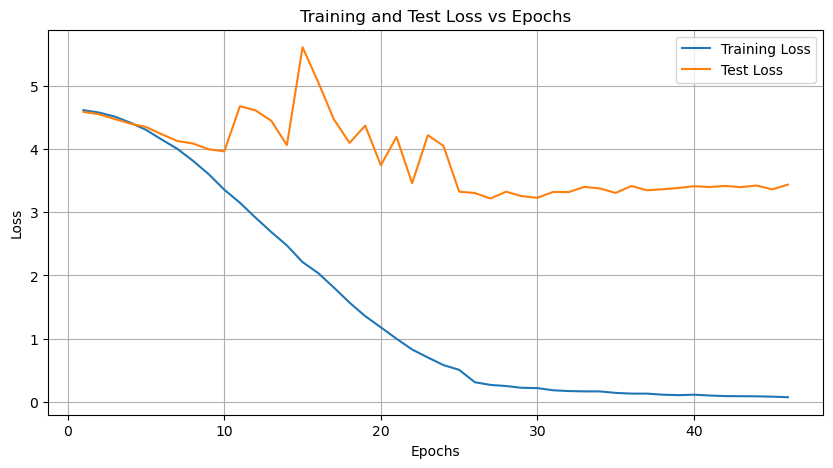

In [16]:
num_epochs = 46

epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

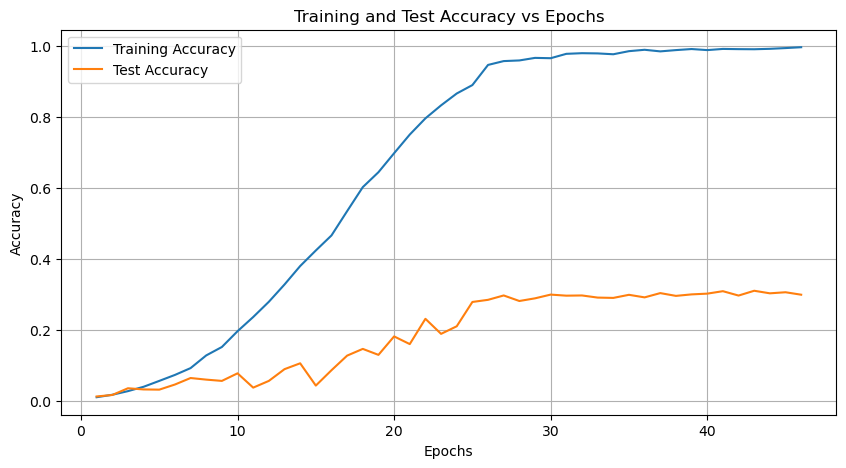

In [18]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()  

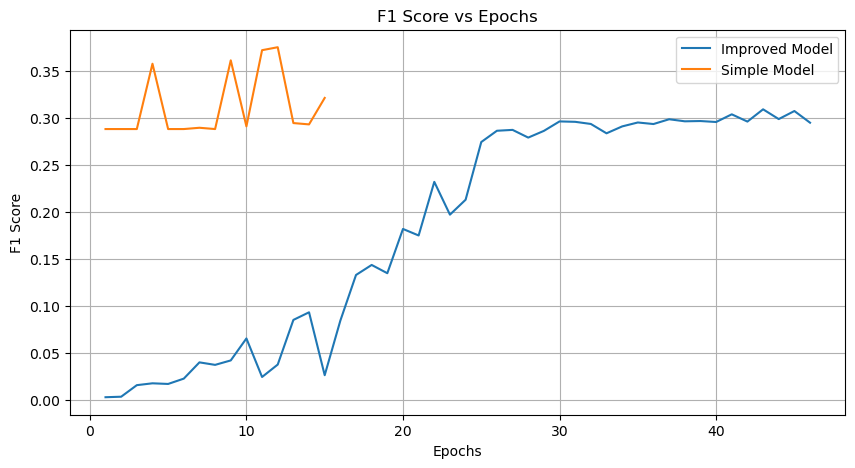

In [20]:
# Plot F1 Score
plt.figure(figsize=(10, 5))

# Improved Model F1 Scores
plt.plot(epochs, f1_scores, linestyle='-', label="Improved Model")

# Plot the F1 values from the Baseline Model, this is hard-coded in
plt.plot(
    range(1, 16), 
    [0.2885368466152528, 0.2885368466152528, 0.2885368466152528, 0.35800560282056604, 
     0.2885368466152528, 0.2885368466152528, 0.28990515812498047, 0.2885368466152528, 
     0.36161119202439296, 0.2913618247972723, 0.3724076408386039, 0.3755616336834515, 
     0.29490095228198265, 0.29349818381047593, 0.32165556746495966], linestyle='-', label="Simple Model"
)

# Formatting the plot
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
baseline = [0.01] * 15

# Plot improved model (all 50 epochs)
plt.plot(range(1, num_epochs + 1), learning_rates, marker='o', linestyle='-', label="Improved Model")
# Plot baseline model (up to epoch 15)
plt.plot(range(1, 16), baseline, linestyle='--', color='red', label="Baseline Model")
plt.title("Learning Rate vs. Epoch Number")
plt.xlabel("Epoch Number")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'learning_rates' is not defined